In [4]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
import polars as pl

In [5]:
# Step 1： 数据加载 加载训练集和验证集，确保训练和验证数据格式正确
train = pl.scan_parquet("training.parquet").collect().to_pandas()
valid = pl.scan_parquet("validation.parquet").collect().to_pandas()
print(f"Training set: {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Validation set: {valid.shape[0]} rows, {valid.shape[1]} columns")

Training set: 6853440 rows, 95 columns
Validation set: 337832 rows, 95 columns


In [6]:
# Step 2: 定义特征列和目标列
# CONFIG 类保存了模型的随机种子、目标列名称和特征列名称
class CONFIG:
    seed = 42  # 随机种子，保证实验可重复性
    target_col = "responder_6"  # 目标列名称
    # 特征列由 79 个基础特征和 9 个延迟特征组成
    feature_cols = [f"feature_{idx:02d}" for idx in range(79)] + \
                   [f"responder_{idx}_lag_1" for idx in range(9)]

In [7]:
# Step 3: 分组统计
# 按 symbol_id 分组，计算每个分组的目标列均值，存储在字典中
y_means = {symbol_id: -1 for symbol_id in train["symbol_id"].unique()}
for symbol_id, gdf in train.groupby("symbol_id"):  # 按 symbol_id 分组
    y_means[symbol_id] = gdf[CONFIG.target_col].mean()  # 计算目标列均值
print("Y means computed for all symbol IDs.")  # 均值计算完成

Y means computed for all symbol IDs.


In [14]:
lags_data = pl.scan_parquet("/Users/kyleee/code/project/kaggle_competition/data/lags.parquet/date_id=0/part-0.parquet").collect().to_pandas()
print(lags_data.head())

   date_id  time_id  symbol_id  responder_0_lag_1  responder_1_lag_1  \
0        0        0          0          -0.442215          -0.322407   
1        0        0          1          -0.651829          -1.707840   
2        0        0          2          -0.656373          -0.264575   
3        0        0          3          -0.188186          -0.190970   
4        0        0          4          -0.257462          -0.471325   

   responder_2_lag_1  responder_3_lag_1  responder_4_lag_1  responder_5_lag_1  \
0           0.143594          -0.926890          -0.782236          -0.036595   
1          -0.893942          -1.065488          -1.871338          -0.615652   
2          -0.892879          -1.511886          -1.033480          -0.378265   
3          -0.701490           0.098453          -1.015506          -0.054984   
4          -0.297420           0.074018          -0.324194          -0.597093   

   responder_6_lag_1  responder_7_lag_1  responder_8_lag_1  
0          -1.30574

In [15]:
# Step 4: 模型训练
# 初始化 XGBoost 模型并使用训练数据进行训练
def get_model(seed):
    # 创建一个 XGBoost 模型实例
    XGB_Params = {
        'learning_rate': 0.05,
        'max_depth': 6,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1,
        'reg_lambda': 5,
        'random_state': seed,
        'tree_method': 'gpu_hist',
        'device' : 'cuda',
        'n_gpus' : 2,
    }
    XGB_Model = XGBRegressor(**XGB_Params)
    return XGB_Model

model = get_model(CONFIG.seed)  # 使用固定随机种子初始化模型

# 提取训练特征和目标列
X_train = train[CONFIG.feature_cols]  # 特征列
y_train = train[CONFIG.target_col]  #
w_train = train["weight"] if "weight" in train.columns else None  # 样本权重（如果存在）

# 模型训练
model.fit(X_train, y_train, sample_weight=w_train)  # 使用样本权重进行训练
print("Model training completed.")  # 训练完成


Model training completed.


In [16]:
# Step 5: 模型验证
# 验证模型在验证集上的整体表现和分组表现
cv_detail = {}  # 用于存储每个分组的 R² 分数
for symbol_id, gdf in valid.groupby("symbol_id"):  # 按 symbol_id 分组
    # 提取验证集的特征和目标列
    X_valid = gdf[CONFIG.feature_cols]
    y_valid = gdf[CONFIG.target_col]
    w_valid = gdf["weight"] if "weight" in gdf.columns else None  # 样本权重（如果存在）
    y_pred_valid = model.predict(X_valid)  # 模型预测
    # 计算分组的 R² 分数
    cv_detail[symbol_id] = r2_score(y_valid, y_pred_valid, sample_weight=w_valid)

# 整体验证分数（R²）
valid_score = r2_score(
    valid[CONFIG.target_col],
    model.predict(valid[CONFIG.feature_cols]),
    sample_weight=valid["weight"] if "weight" in valid.columns else None
)
print(f"Overall CV Score: {valid_score}")  # 输出整体验证分数


Overall CV Score: 0.007621993439227759


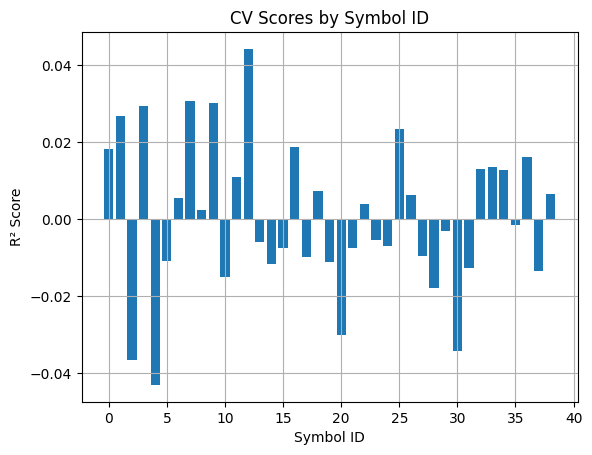

In [17]:
# Step 6: 可视化分组性能
# 绘制柱状图，展示每个分组的验证分数
sids = list(cv_detail.keys())  # 分组 ID
scores = list(cv_detail.values())  # 每个分组的 R² 分数

plt.bar(sids, scores)  # 绘制柱状图
plt.xlabel("Symbol ID")  # 横轴为 symbol_id
plt.ylabel("R² Score")  # 纵轴为 R² 分数
plt.title("CV Scores by Symbol ID")  # 图表标题
plt.grid()  # 添加网格线
plt.show()  # 显示图表

In [18]:
# Step 7: 模型保存
# 将模型、验证分数和分组信息保存到文件，便于后续分析
result = {
    "model": model,  # 训练好的模型
    "cv": valid_score,  # 整体验证分数
    "cv_detail": cv_detail,  # 分组验证分数
    "y_mean": y_means,  # 每个 symbol_id 的目标均值
}

# 使用 pickle 序列化保存
with open("result.pkl", "wb") as fp:
    pickle.dump(result, fp)
print("Model and results saved to result.pkl.")  # 保存完成

Model and results saved to result.pkl.
